# Add thư viện

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from keras.models import load_model
from keras.utils import plot_model

# Load dữ liệu
Bộ dữ liệu MIT-BIH 


In [55]:
df_train = pd.read_csv("C:/Users/thin/Desktop/AI_ECG/TRAIN_DATA_DA.csv", header=None)
#df_train = df_train.sample(frac=1)
df_test = pd.read_csv("C:/Users/thin/Desktop/AI_ECG/TEST_DATA_DA.csv", header=None)

Y = np.array(df_train[360].values).astype(np.int8)
X = np.array(df_train[list(range(360))].values)[..., np.newaxis]

Y_test = np.array(df_test[360].values).astype(np.int8)
X_test = np.array(df_test[list(range(360))].values)[..., np.newaxis]

# Xây dựng mô hình CNN:

In [56]:
def get_model():
    nclass = 2
    inp = Input(shape=(360, 1))
    img_1 = Convolution1D(16, kernel_size=15, activation=activations.relu, padding="valid")(inp)
    img_1 = MaxPool1D(pool_size=3)(img_1)
    img_1 = Convolution1D(64, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(16, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model
model = get_model()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 360, 1)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 346, 16)           256       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 115, 16)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 111, 64)           5184      
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                104

# Thực hiện Trainning

In [57]:
file_path = "CNN_HPCC.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

h=model.fit(X, Y, epochs=40, batch_size=2000, verbose=1, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

Train on 65638 samples, validate on 7294 samples
Epoch 1/40
65638/65638 [==============================] - 9s 140us/step - loss: 0.5174 - acc: 0.7503 - val_loss: 0.3745 - val_acc: 0.8294

Epoch 00001: val_acc improved from -inf to 0.82945, saving model to CNN_HPCC.h5
Epoch 2/40
65638/65638 [==============================] - 9s 135us/step - loss: 0.3163 - acc: 0.8502 - val_loss: 0.2673 - val_acc: 0.8917

Epoch 00002: val_acc improved from 0.82945 to 0.89169, saving model to CNN_HPCC.h5
Epoch 3/40
65638/65638 [==============================] - 9s 133us/step - loss: 0.2298 - acc: 0.9169 - val_loss: 0.2122 - val_acc: 0.9382

Epoch 00003: val_acc improved from 0.89169 to 0.93817, saving model to CNN_HPCC.h5
Epoch 4/40
65638/65638 [==============================] - 9s 137us/step - loss: 0.1935 - acc: 0.9402 - val_loss: 0.1900 - val_acc: 0.9472

Epoch 00004: val_acc improved from 0.93817 to 0.94722, saving model to CNN_HPCC.h5
Epoch 5/40
65638/65638 [==============================] - 9s 137us


Epoch 00038: val_acc did not improve from 0.97299
Epoch 00038: early stopping


# Vẽ đồ thị acc & loss

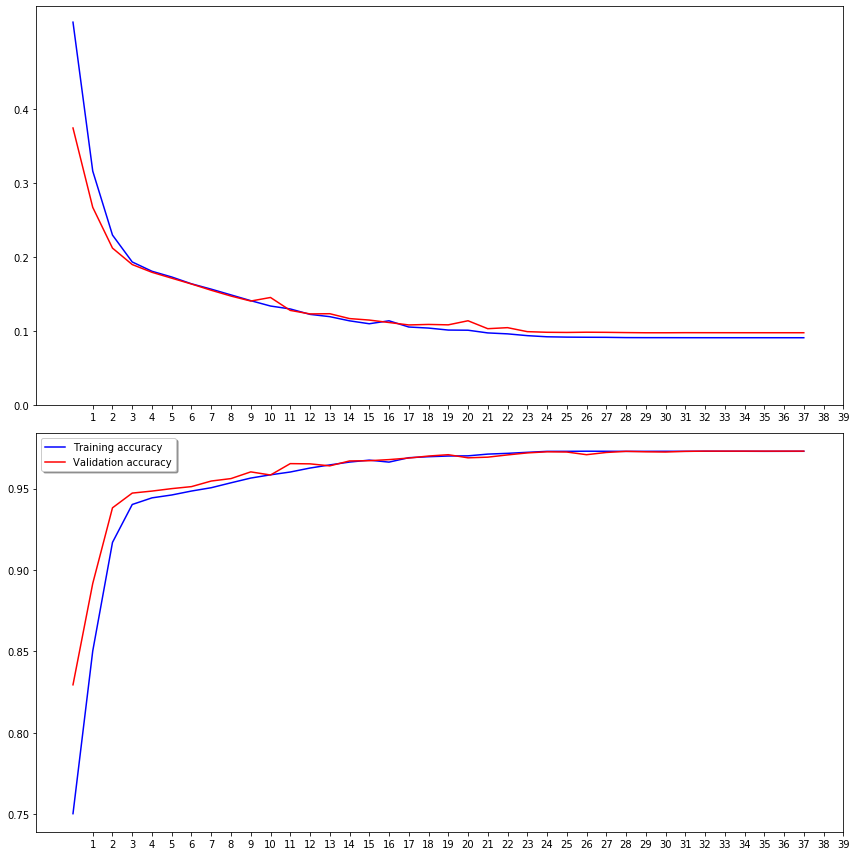

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(h.history['loss'], color='b', label="Training loss")
ax1.plot(h.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 40, 1))
ax1.set_yticks(np.arange(0, 0.5, 0.1))

ax2.plot(h.history['acc'], color='b', label="Training accuracy")
ax2.plot(h.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 40, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Load model

In [62]:
model = load_model('CNN_HPCC.h5')

# Dự đoán

In [63]:
pred_test = model.predict(X_test,verbose=1)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(Y_test, pred_test, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

2400/2400 [==============================] - 0s 136us/step
Test f1 score : 0.9179117188001709 
Test accuracy score : 0.9183333333333333 


# Kết quả dự đoán

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.99      0.92      1200
           1       0.99      0.85      0.91      1200

    accuracy                           0.92      2400
   macro avg       0.93      0.92      0.92      2400
weighted avg       0.93      0.92      0.92      2400

Confusion matrix
[[1188   12]
 [ 184 1016]]


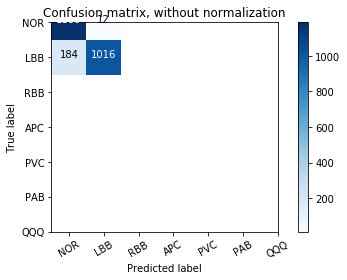

In [64]:
c=confusion_matrix(Y_test,pred_test)
print('Classification Report')
print(classification_report(Y_test, pred_test))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    import itertools
    print('Confusion matrix')
    print(cm)
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(c, classes=['NOR', 'LBB', 'RBB', 'APC', 'PVC', 'PAB', 'QQQ'],
                      title='Confusion matrix, without normalization')

# Vẽ random 20 nhịp được dự đoán

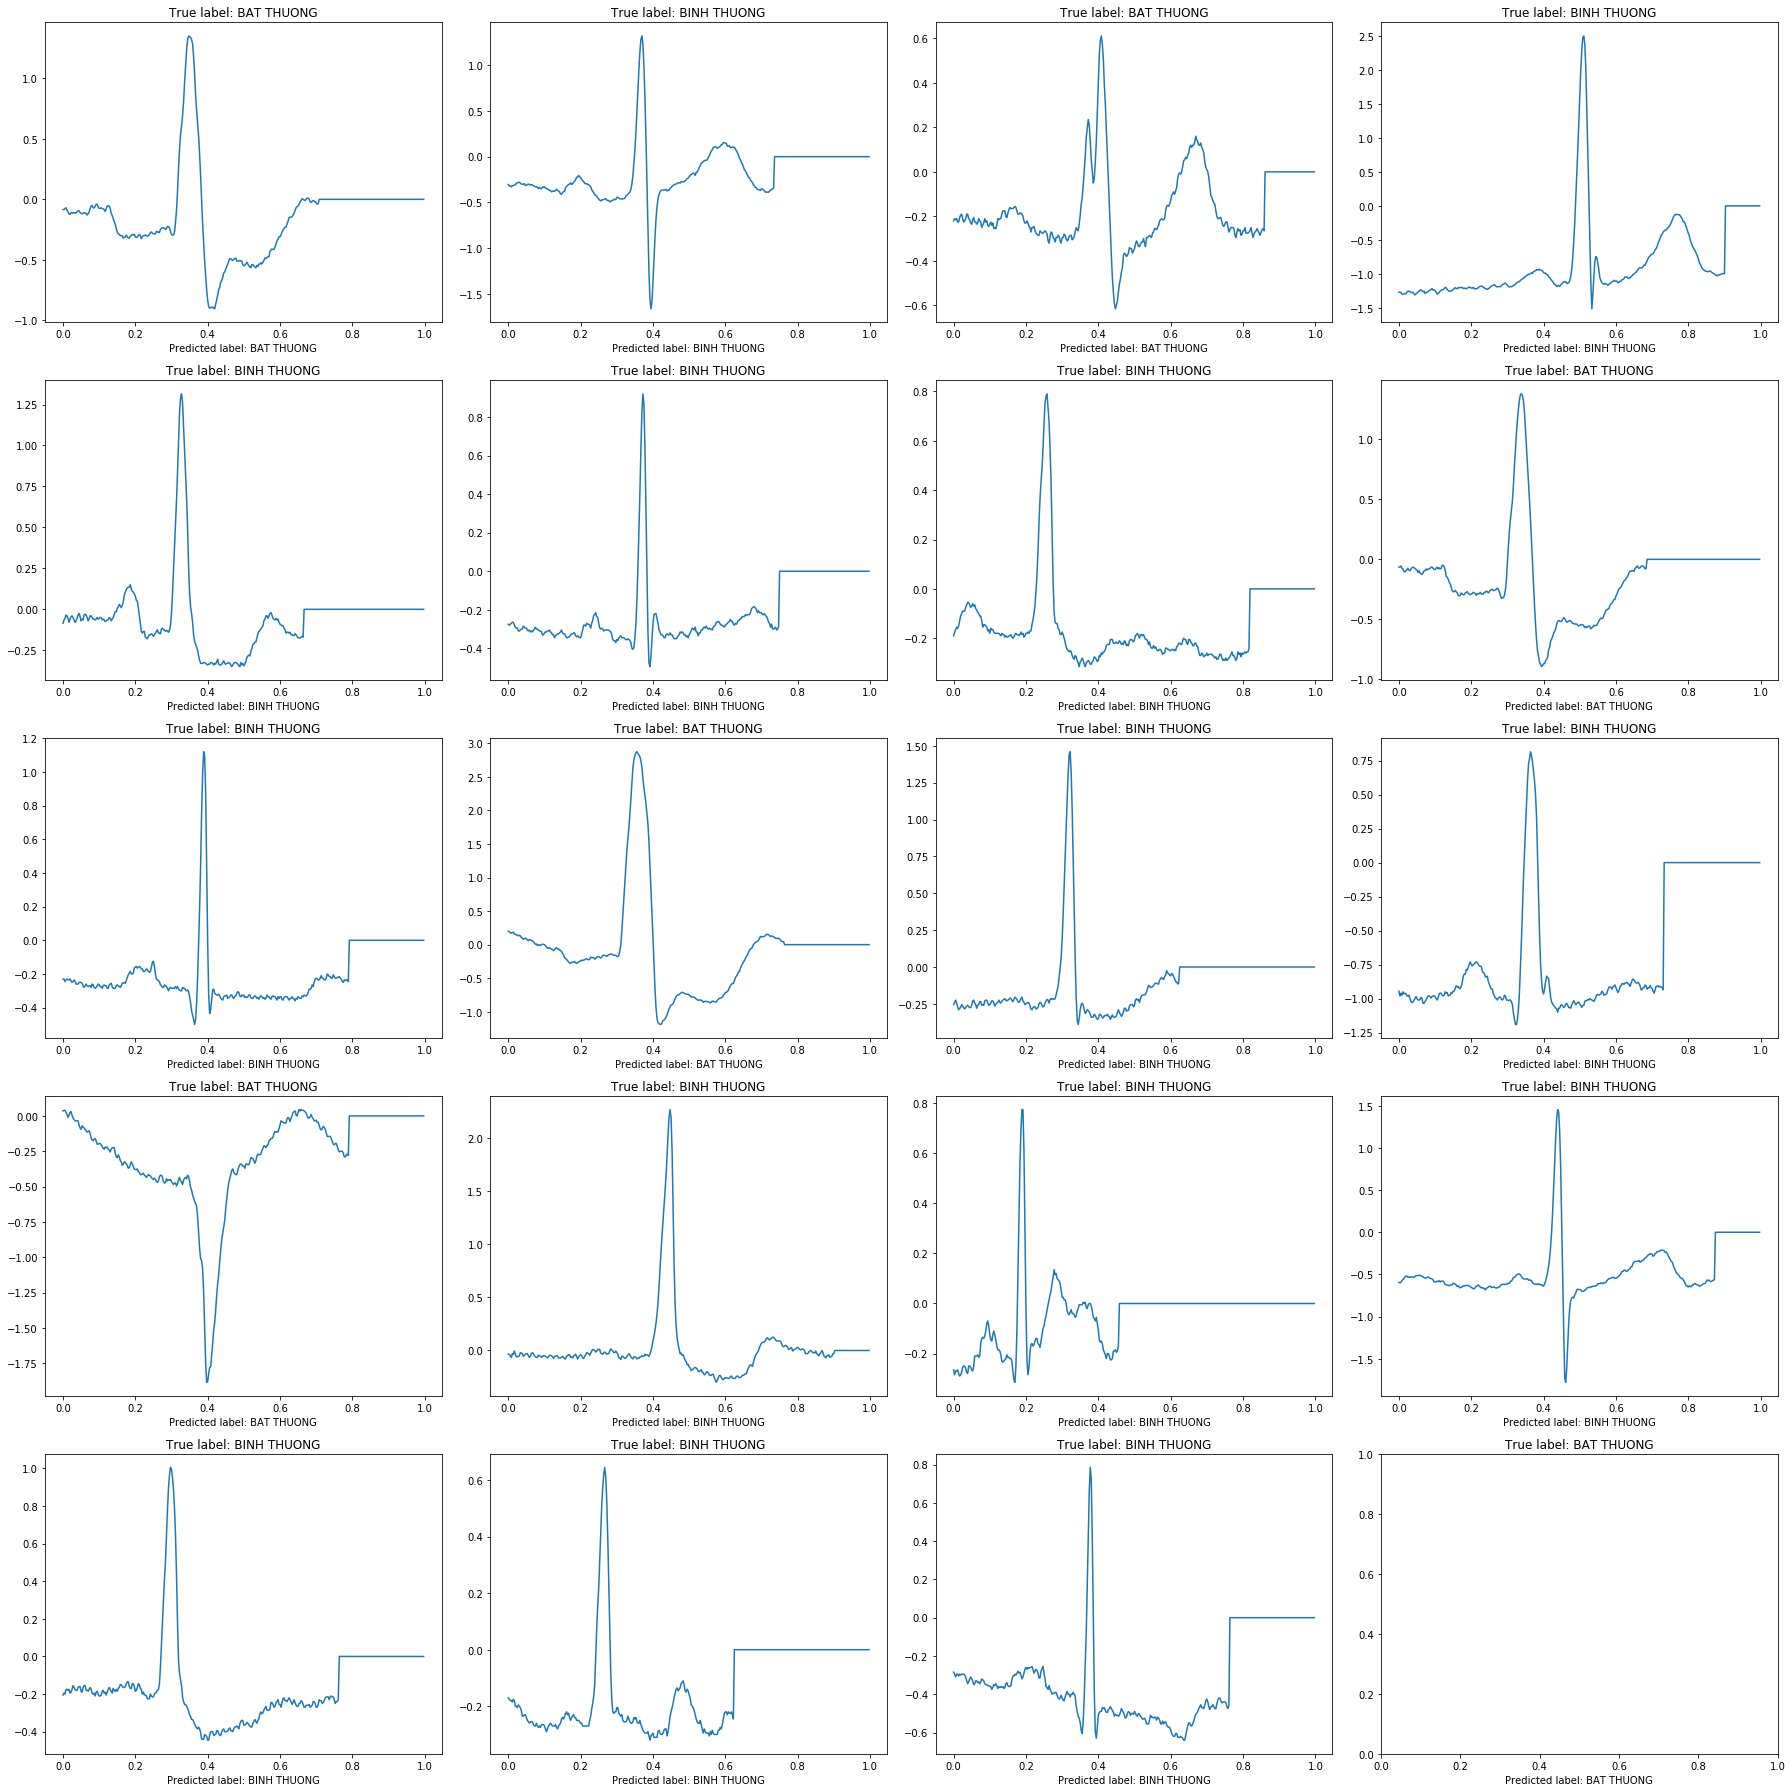

In [66]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 25))
True_Label=list()
Pred_Label=list()
i=np.random.randint(0,1400,20)
#i=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
t=np.arange(0,360)
ts=t/360
for j in range(len(i)):
    if Y_test[i[j]]==0:
        True_Label.append('BINH THUONG')
    elif Y_test[i[j]]==1:
        True_Label.append('BAT THUONG')
    elif Y_test[i[j]]==1:
        True_Label.append('BAT THUONG')
    elif Y_test[i[j]]==1:
        True_Label.append('BAT THUONG')
    elif Y_test[i[j]]==1:
        True_Label.append('BAT THUONG')
    elif Y_test[i[j]]==1:
        True_Label.append('BAT THUONG')
    elif Y_test[i[j]]==1:
        True_Label.append('BAT THUONG')
for j in range(len(i)):
    if pred_test[i[j]]==0:
        Pred_Label.append('BINH THUONG')
    elif pred_test[i[j]]==1:
        Pred_Label.append('BAT THUONG')
    elif pred_test[i[j]]==1:
        Pred_Label.append('BAT THUONG')
    elif pred_test[i[j]]==1:
        Pred_Label.append('BAT THUONG')
    elif pred_test[i[j]]==1:
        Pred_Label.append('BAT THUONG')
    elif pred_test[i[j]]==1:
        Pred_Label.append('BAT THUONG')
    elif pred_test[i[j]]==1:
        Pred_Label.append('BAT THUONG')
for j in range(len(i)):
    plt.plot(ts,X_test[i[j-1]])
    plt.subplot(5, 4, j+1)
    plt.xlabel('Predicted label: '+ Pred_Label[j])
    plt.title('True label: '+ True_Label[j])
plt.tight_layout()
plt.show()

In [10]:
print(Y)

[0 0 1 ... 0 0 0]


In [11]:
 test = pd.read_csv("/Users/vibuitruong/Documents/ECG/DATA.csv", header=None)

label_test = np.array(test[360].values).astype(np.int8)
data_test = np.array(test[list(range(360))].values)[..., np.newaxis]

FileNotFoundError: [Errno 2] File b'/Users/vibuitruong/Documents/ECG/DATA.csv' does not exist: b'/Users/vibuitruong/Documents/ECG/DATA.csv'

In [ ]:
i=int(input('Chọn nhịp để dự đoán: '))
model = load_model('baseline_cnn_mitbih.h5')
pred_test = model.predict(data_test,verbose=1)
pred_test = np.argmax(pred_test, axis=-1)
plt.figure(figsize=(5, 5))
True_Label=list()
Pred_Label=list()

#i=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

if label_test[i]==0:
    True_Label.append('NOR')
elif label_test[i]==1:
    True_Label.append('LBB')
elif label_test[i]==2:
    True_Label.append('RBB')
elif label_test[i]==3:
    True_Label.append('APC')
elif label_test[i]==4:
    True_Label.append('PVC')
elif label_test[i]==5:
    True_Label.append('PAB')
elif label_test[i]==6:
    True_Label.append('QQQ')
    
if pred_test[i]==0:
    Pred_Label.append('NOR')
elif pred_test[i]==1:
    Pred_Label.append('LBB')
elif pred_test[i]==2:
    Pred_Label.append('RBB')
elif pred_test[i]==3:
    Pred_Label.append('APC')
elif pred_test[i]==4:
    Pred_Label.append('PVC')
elif pred_test[i]==5:
    Pred_Label.append('PAB')
elif pred_test[i]==6:
    Pred_Label.append('QQQ')
    
plt.plot(data_test[i])
plt.xlabel('Predicted label: '+ Pred_Label[0])
plt.title('True label: '+ True_Label[0])
plt.tight_layout()
plt.show()

In [ ]:
print('Classification Report')
print(classification_report(label_test, pred_test))
print(confusion_matrix(label_test, pred_test))
